In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.stats as sps

import pulse2percept as p2p
import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-10 16:22:51,050 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
fname = '../../results/A_crossval-swarm_12-005_2018-01-09_07-00-36.pickle'

In [3]:
y_true, y_pred, best_params, specifics = pickle.load(open(fname, 'rb'))

In [4]:
specifics

{'amplitude': 2.0,
 'electrodes': None,
 'fit_params': {'decay_const': 0,
  'loc_od_x': 15.5,
  'loc_od_y': 1.2,
  'scoring_weights': {'area': 0.001,
   'major_axis_length': 0.1,
   'minor_axis_length': 0.1,
   'orientation': 100.0},
  'use_ofl': False,
  'use_persp_trafo': False},
 'model_params': {'csmode': 'gaussian',
  'sampling': 200,
  'sensitivity_rule': 'decay',
  'thresh': 1.0},
 'n_folds': 5,
 'now': '2018-01-09_07-00-36',
 'optimizer': ParticleSwarmOptimizer(estimator=SpatialModelRegressor(csmode='gaussian', sampling=200,
            sensitivity_rule='decay', thresh=1.0, x_range=(-30, 30),
            y_range=(-20, 20)),
             greater_is_better=False, max_iter=100, min_func=0.01,
             search_params={'implant_y': (-1000, 1000), 'cswidth': (10, 1000), 'implant_rot': array([-1.309 , -0.2618]), 'implant_x': (-1500, 1500)},
             swarm_size=40, verbose=True),
 'random_state': 42,
 'regressor': SpatialModelRegressor(csmode='gaussian', sampling=200,
          

In [5]:
p2pspatial.model_selection.crossval_score(y_true, y_pred, metric='r2')

[-1.9093658537742624,
 -1.7457596519335872,
 -1.7687137337662464,
 -1.8514652108809759,
 -1.6547088170803417]

## Plot all

In [70]:
data = {
    'A': {'12-005': '../../results/A_crossval-swarm_12-005_2018-01-09_07-00-36.pickle',
          '51-009': '../../results/A_crossval-swarm_51-009_2018-01-09_07-06-53.pickle',
          '52-001': '../../results/A_crossval-swarm_52-001_2018-01-09_07-16-27.pickle'},
    'B': {'12-005': '../../results/B_crossval-swarm_12-005_2018-01-09_07-13-05.pickle',
          '51-009': '../../results/B_crossval-swarm_51-009_2018-01-09_07-08-24.pickle',
          '52-001': '../../results/B_crossval-swarm_52-001_2018-01-09_07-09-40.pickle'},
    'C': {'12-005': '../../results/C_crossval-swarm_12-005_2018-01-09_04-22-22.pickle',
          '51-009': '../../results/C_crossval-swarm_51-009_2018-01-09_04-25-47.pickle',
          '52-001': '../../results/C_crossval-swarm_52-001_2018-01-09_04-37-32.pickle'}
}

In [71]:
models = np.sort(list(data.keys()))
models

array(['A', 'B', 'C'], 
      dtype='<U1')

In [72]:
subjects = set()
for _, v in data.items():
    subjects = subjects.union(v)
subjects = np.sort(list(subjects))
subjects

array(['12-005', '51-009', '52-001'], 
      dtype='<U6')

In [89]:
metric = 'var_explained'
weights = pd.Series(specifics['fit_params']['scoring_weights'])
scores_mu = {}
scores_std = {}
for model, datafile in data.items():
    mu = []
    std = []
    for subject in subjects:
        y_true, y_pred, best_params, specifics = pickle.load(open(datafile[subject], 'rb'))
        scores = p2pspatial.model_selection.crossval_score(y_true, y_pred,
                                                           metric=metric,
                                                           weights=weights)
        mu.append(np.mean(scores))
        std.append(np.std(scores))
    scores_mu[model] = mu
    scores_std[model] = std

In [87]:
scores_mu

{'A': [-1.0945469724089107, -0.68901622970039889, -0.68686409520383729],
 'B': [0.090387652617166511, 0.07530219284764525, 0.086042635323182723],
 'C': [0.020110044020279251, 0.00063002444420004607, 0.12232289253420188]}

In [75]:
# def label_diff(i,j,text,X,Y):
#     x = (X[i]+X[j])/2
#     y = 1.1*max(Y[i], Y[j])
#     dx = abs(X[i]-X[j])

#     props = {'connectionstyle':'bar','arrowstyle':'-',\
#                  'shrinkA':20,'shrinkB':20,'lw':2}
#     ax.annotate(text, xy=(X[i],y+7), zorder=10)
#     ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

# # Call the function
# label_diff(0,1,'p=0.0370',X,menMeans)

['all', 'area', 'major_axis_length', 'minor_axis_length', 'orientation']


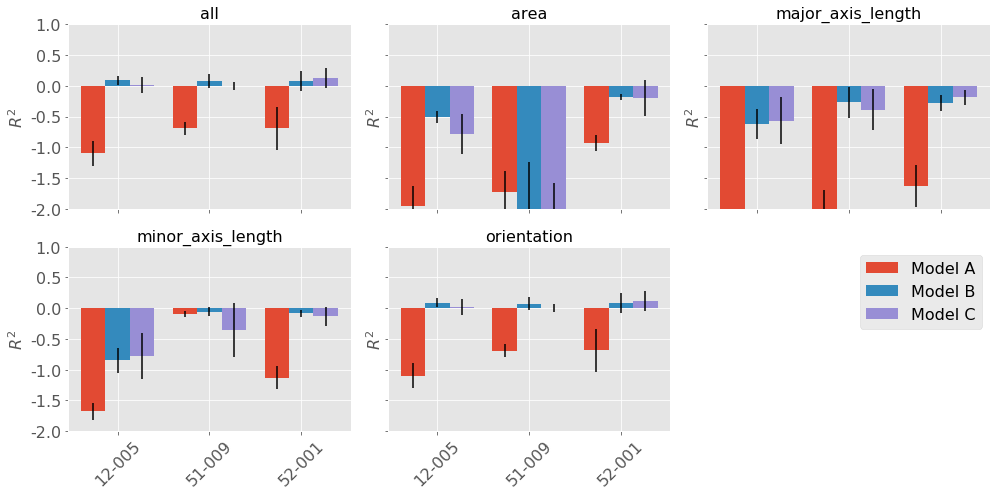

In [95]:
metric = 'r2'
weights = pd.Series(specifics['fit_params']['scoring_weights'])
keys = ['all'] + list(np.sort(list(specifics['fit_params']['scoring_weights'])))
print(keys)
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(14, 7))
# plt.figure(figsize=(12, 6))

N = len(subjects)
width = 0.8 / N
ind = np.arange(N)

for key, ax in zip(keys, axes.ravel()):
    rects = []
    for m, model in enumerate(models):
        mu = []
        std = []
        for subject in subjects:
            y_true, y_pred, best_params, specifics = pickle.load(open(data[model][subject], 'rb'))
            scores = p2pspatial.model_selection.crossval_score(y_true, y_pred, key=key,
                                                               metric=metric,
                                                               weights=weights)
            mu.append(np.mean(scores))
            std.append(np.std(scores))
#         if m > 1:
#             mu = [0, 0, 0]
#             std = [0, 0, 0]
        rects.append(ax.bar(ind + m * width, mu, width, yerr=std))
    ax.set_xticks(ind + (len(models) - 1) / 2 * width)
    ax.set_xticklabels(subjects, rotation=45, ha='center', fontsize=16)
    ax.set_yticks(np.arange(-2, 1.01, 0.5))
    ax.set_yticklabels(np.arange(-2, 1.01, 0.5), fontsize=16)
    ax.set_title(key, fontsize=16)
    ax.set_ylabel('$R^2$', fontsize=16)
axes.ravel()[-1].axis('off')
axes.ravel()[-1].legend([r[0] for r in rects], ['Model ' + mm for mm in models], loc='upper right', fontsize=16)
plt.ylim(-2, 1)
plt.tight_layout()
plt.savefig('results-ABC.png')

In [111]:
model1 = 'A'
model2 = 'C'
for subject in subjects:
    for key in keys:
        y_true, y_pred, best_params, specifics = pickle.load(open(data[model1][subject], 'rb'))
        scores1 = p2pspatial.model_selection.crossval_score(y_true, y_pred, key=key,
                                                           metric=metric,
                                                           weights=weights)
        y_true, y_pred, best_params, specifics = pickle.load(open(data[model2][subject], 'rb'))
        scores2 = p2pspatial.model_selection.crossval_score(y_true, y_pred, key=key,
                                                           metric=metric,
                                                           weights=weights)
        print(subject, key, sps.ttest_ind(scores1, scores2))

12-005 all Ttest_indResult(statistic=-9.1955656229248461, pvalue=1.5817951079603766e-05)
12-005 area Ttest_indResult(statistic=-5.0661957214107556, pvalue=0.0009695699021311443)
12-005 major_axis_length Ttest_indResult(statistic=-6.5891684680903531, pvalue=0.00017131100915286906)
12-005 minor_axis_length Ttest_indResult(statistic=-4.582748910662894, pvalue=0.0017955314117918475)
12-005 orientation Ttest_indResult(statistic=-9.1506210304717008, pvalue=1.6399895039934193e-05)
51-009 all Ttest_indResult(statistic=-10.719518116130274, pvalue=5.0411419073368823e-06)
51-009 area Ttest_indResult(statistic=1.8952781703732493, pvalue=0.094653674983491157)
51-009 major_axis_length Ttest_indResult(statistic=-6.4086110844047335, pvalue=0.00020722336682953266)
51-009 minor_axis_length Ttest_indResult(statistic=1.1792010473666983, pvalue=0.27219625798204561)
51-009 orientation Ttest_indResult(statistic=-10.725245847967759, pvalue=5.0209022502993524e-06)
52-001 all Ttest_indResult(statistic=-4.220768

## Plot histogram of errors

In [ ]:
from snippets import circstats

In [142]:
import itertools

In [150]:
list(itertools.product(models, subjects))

[('A', '12-005'),
 ('A', '51-009'),
 ('A', '52-001'),
 ('B', '12-005'),
 ('B', '51-009'),
 ('B', '52-001'),
 ('C', '12-005'),
 ('C', '51-009'),
 ('C', '52-001')]

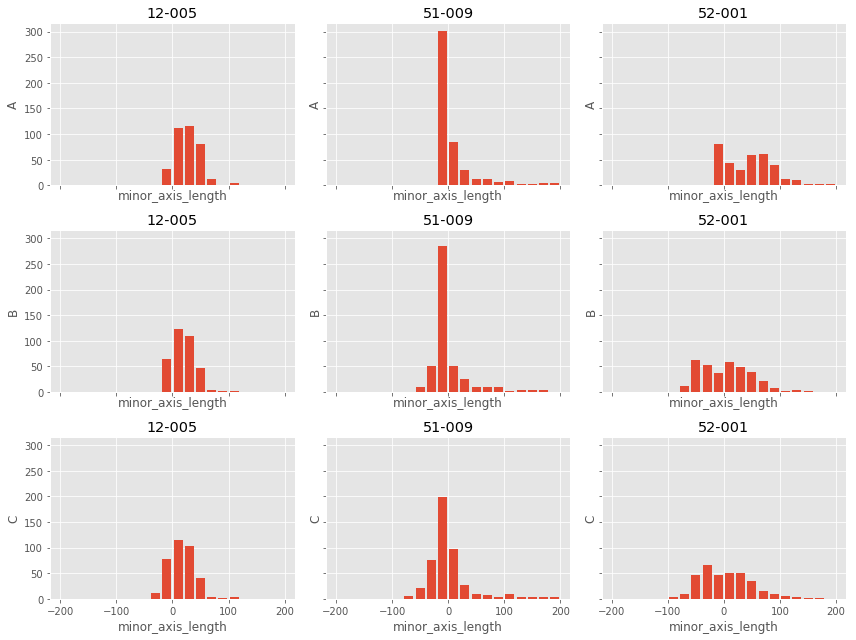

In [182]:
key = 'minor_axis_length'
xrange = (-200, 200)
fig, axes = plt.subplots(nrows=len(models), ncols=len(subjects),
                         sharex=True, sharey=True,
                         figsize=(12, 3 * len(models)))
for specs, ax in zip(list(itertools.product(models, subjects)), axes.ravel()):
    model, subject = specs
    y_true, y_pred, _, _ = pickle.load(open(data[model][subject], 'rb'))
    err = []
    for yt, yp in zip(y_true, y_pred):
        if key == 'orientation':
            err += list(np.rad2deg(circstats.difference(yt.loc[:, key], yp.loc[:, key])))
        else:
            err += list(yt.loc[:, key] - yp.loc[:, key])
    ax.hist(err, bins=20, range=xrange, rwidth=0.8)
    ax.set_xlabel(key)
    ax.set_ylabel(model)
    ax.set_title(subject)
fig.tight_layout()

(array([   2.,    7.,   16.,   43.,   75.,  130.,   53.,   14.,   12.,    3.]),
 array([-130.22836494, -103.18090732,  -76.1334497 ,  -49.08599209,
         -22.03853447,    5.00892315,   32.05638076,   59.10383838,
          86.151296  ,  113.19875362,  140.24621123]),
 <a list of 10 Patch objects>)

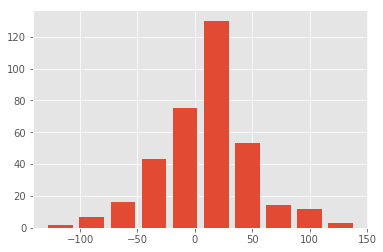

In [135]:
plt.hist(err, rwidth=0.8)